## Visualizing wildfires in the study area
In the first two steps we create GeoDataFrames in order to eventually map between fire sites and hydrologic data (instead of just reading lat/long onto a map, which would be easier)

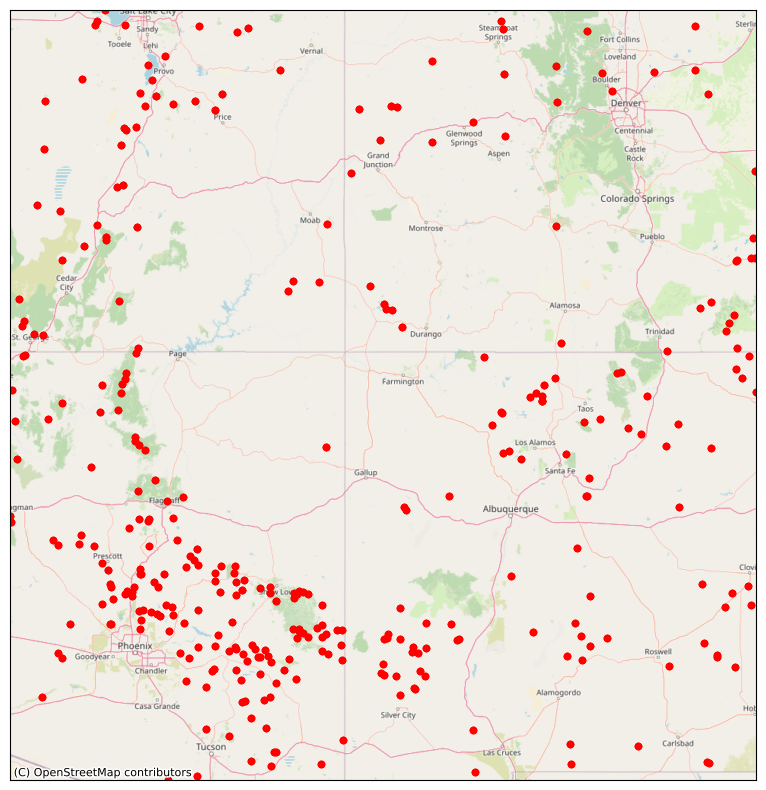

In [14]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import networkx as nx
import matplotlib.pyplot as plt
import contextily as ctx

# Load the MTBS wildfire data CSV
mtbs_df = pd.read_csv('MTBS_Wildfire_Data/wildfire_data.csv')
mtbs_df['geometry'] = mtbs_df.apply(lambda row: Point(row['center_lon'], row['center_lat']), axis=1)
mtbs_gdf = gpd.GeoDataFrame(mtbs_df, geometry='geometry', crs="EPSG:4326")

# Check for valid geometries
mtbs_gdf = mtbs_gdf[mtbs_gdf.is_valid]

# Remove rows with missing geometries
mtbs_gdf = mtbs_gdf.dropna(subset=['geometry'])

# Set the plot size
fig, ax = plt.subplots(figsize=(10, 10))

# Convert GeoDataFrame to the correct CRS
mtbs_gdf = mtbs_gdf.to_crs(epsg=3857)

mtbs_gdf.plot(ax=ax, marker='o', color='red', markersize=20, alpha=0.6)  # Plot base points

# Manually set the extent
minx, miny, maxx, maxy = mtbs_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_xticks([])
ax.set_ylim(miny, maxy)
ax.set_yticks([])

# Add basemap using contextily
ctx.add_basemap(ax, crs=mtbs_gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Show the plot
plt.show()


## Visualizing where water quality sampling sites are in the study area

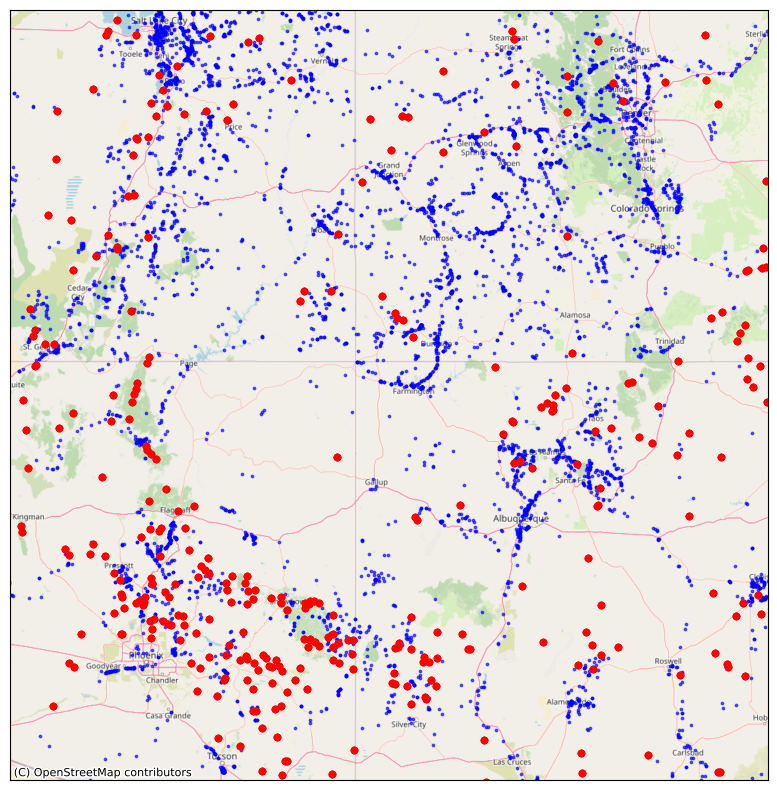

In [21]:

# Load the USGS water quality sites CSV
usgs_df = pd.read_csv('USGS_Water_Quality_Sites/wq_site_information.csv')

# Rename columns for easier access
usgs_df = usgs_df.rename(columns={
    'MonitoringLocationIdentifier': 'site_id',
    'LatitudeMeasure': 'lat',
    'LongitudeMeasure': 'long'
})

# Create a geometry column
usgs_df['geometry'] = usgs_df.apply(lambda row: Point(row['long'], row['lat']), axis=1)

# Convert to GeoDataFrame
usgs_gdf = gpd.GeoDataFrame(usgs_df, geometry='geometry', crs="EPSG:4326")

# Check for valid geometries
usgs_gdf = usgs_gdf[usgs_gdf.is_valid]

# Remove rows with missing geometries
usgs_gdf = usgs_gdf.dropna(subset=['geometry'])

# Set the plot size
fig, ax = plt.subplots(figsize=(10, 10))

# Convert GeoDataFrame to the correct CRS
usgs_gdf = usgs_gdf.to_crs(epsg=3857)

# Plot the GeoDataFrame
usgs_gdf.plot(ax=ax, marker='o', color='blue', markersize=3, alpha=0.6)
mtbs_gdf.plot(ax=ax, marker='o', color='red', markersize=20, alpha=0.8)  # Plot base points


# Manually set the extent
minx, miny, maxx, maxy = usgs_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_xticks([])
ax.set_ylim(miny, maxy)
ax.set_yticks([])

# Add basemap using contextily
ctx.add_basemap(ax, crs=usgs_gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Show the plot
plt.show()

## Visualizing hydrologic data

Reading file


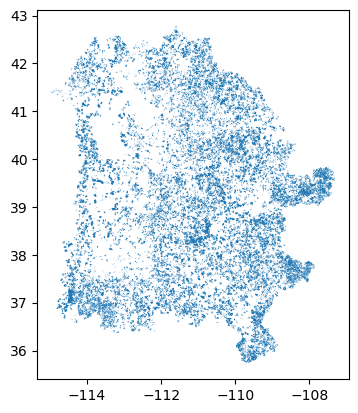

In [22]:
shapefile_path = "NHD_Watershed_Shapefiles/Utah/NHDFlowline.shp"

print("Reading file")
# Load the shapefile into a GeoDataFrame
gdf = gpd.read_file(shapefile_path)

# Plot the GeoDataFrame
gdf.plot()

# Show the plot
plt.show()

## Visualizing the watershed directionality (where is the water heading?)

In [4]:
# Load NHD flowline shapefiles
nhd_directory = 'NHD_Watershed_Shapefiles'

# Find the shapefiles
shapefiles = []
for root, dirs, files in os.walk(nhd_directory):
    for file in files:
        if file.endswith('.shp'):
            base_name = os.path.splitext(os.path.join(root, file))[0]
            if os.path.exists(base_name + '.shx') and os.path.exists(base_name + '.dbf'):
                shapefiles.append(os.path.join(root, file))

# Create a list of them to concat together
flowlines_list = []
for shapefile in shapefiles:
    try:
        print(f"Appending flowlines from {shapefile}")
        gdf = gpd.read_file(shapefile)
        print(f"Appended flowlines from {shapefile}")
        flowlines_list.append(gdf)
    except Exception as e:
        print(f"Error reading {shapefile}: {e}")

# If we found shapefiles:
if flowlines_list:
    # Concat them together to create 1 shapefile with our hydrologic data
    nhd_flowlines = gpd.GeoDataFrame(pd.concat(flowlines_list, ignore_index=True))

    # Save the GDF as a shapefile for ease of access
    gdf.to_file("concatenated_flowlines.shp")
    print("Concatenated GDFs")

    # Ensure all GeoDataFrames have the same CRS
    mtbs_gdf = mtbs_gdf.to_crs(nhd_flowlines.crs)
    usgs_gdf = usgs_gdf.to_crs(nhd_flowlines.crs)

    # Function to find the closest flowline segment to a given point
    def find_closest_flowline(point, flowlines):
        return flowlines.distance(point).idxmin()

    # Function to trace the downstream path from a given flowline segment
    def trace_downstream(flowline_id, graph):
        downstream_path = []
        current_id = flowline_id
        
        while current_id in graph:
            downstream_path.append(current_id)
            try:
                current_id = list(graph.successors(current_id))[0]
            except IndexError:
                break
        
        return downstream_path

    # Map flow directions using FlowDir attribute
    def map_flow_directions(flowlines):
        flow_direction = {}
        for idx, row in flowlines.iterrows():
            next_downstream_id = row['FlowDir']
            if next_downstream_id != -1:
                flow_direction[idx] = next_downstream_id
        return flow_direction

    flow_direction = map_flow_directions(nhd_flowlines)

    # Create a directed graph for the flowlines
    G = nx.DiGraph()
    for idx, row in nhd_flowlines.iterrows():
        if row['FlowDir'] != -1:
            G.add_edge(row['HydroID'], row['FlowDir'])

    # Find the downstream water quality site for each fire site
    results = []

    for fire in mtbs_gdf.itertuples():
        closest_flowline_id = find_closest_flowline(fire.geometry, nhd_flowlines)
        downstream_path_ids = trace_downstream(closest_flowline_id, G)
        downstream_flowlines = nhd_flowlines[nhd_flowlines['HydroID'].isin(downstream_path_ids)]
        
        closest_downstream_site = usgs_gdf[usgs_gdf.intersects(downstream_flowlines.unary_union)].distance(fire.geometry).idxmin()
        closest_site_info = usgs_gdf.loc[closest_downstream_site]
        
        results.append({
            'fire_id': fire.Index,
            'center_lat': fire.center_lat,
            'center_lon': fire.center_lon,
            'downstream_site_id': closest_site_info['site_id'],
            'downstream_site_lat': closest_site_info['lat'],
            'downstream_site_lon': closest_site_info['long']
        })

    results_df = pd.DataFrame(results)
    final_mtbs_df = mtbs_df.merge(results_df[['fire_id', 'downstream_site_id']], left_index=True, right_on='fire_id')

    final_mtbs_df.to_csv('updated_mtbs_output.csv', index=False)
    print("MTBS data has been updated with the nearest downstream water quality site IDs.")

    # Plot the flowlines with basemap
    fig, ax = plt.subplots(figsize=(15, 15))
    nhd_flowlines = nhd_flowlines.to_crs(epsg=3857)
    nhd_flowlines.plot(ax=ax, color='blue', linewidth=0.5)
    ctx.add_basemap(ax, crs=nhd_flowlines.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
    plt.show()

Appending flowlines from NHD_Watershed_Shapefiles/Arizona/NHDFlowline_0.shp
Error reading NHD_Watershed_Shapefiles/Arizona/NHDFlowline_0.shp: 'NHD_Watershed_Shapefiles/Arizona/NHDFlowline_0.shp' not recognized as a supported file format.
Appending flowlines from NHD_Watershed_Shapefiles/Arizona/NHDFlowline_1.shp
Error reading NHD_Watershed_Shapefiles/Arizona/NHDFlowline_1.shp: 'NHD_Watershed_Shapefiles/Arizona/NHDFlowline_1.shp' not recognized as a supported file format.
Appending flowlines from NHD_Watershed_Shapefiles/Colorado/NHDFlowline_0.shp
Error reading NHD_Watershed_Shapefiles/Colorado/NHDFlowline_0.shp: <class 'fiona.ogrext.FeatureBuilder'> returned a result with an exception set
Appending flowlines from NHD_Watershed_Shapefiles/Colorado/NHDFlowline_1.shp


KeyboardInterrupt: 